# Predicting Profitability and Popularity of movies
**In this notebook, we are going to build and test different models to:**

**1) Predict which movies would be profitable**

**2) Predict which movies would be popular**

# 1. Importing the libraries and the data that was obtained from the previous notebook - Data-cleaning

In [79]:
%matplotlib inline 
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.tools.plotting import scatter_matrix
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
#from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

In [80]:
valid_data=pd.read_csv("/home/angps/Documents/DSC3216 (1)/project/valid_data.csv")

In [81]:
valid_data.head(2)

,index,adult,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,tagline,title,vote_average,vote_count,Animation,Crime,History,Horror,Drama,Mystery,Documentary,Fantasy,Action,Thriller,Music,Comedy,Family,Romance,Western,War,Foreign,Adventure,Western Europe,Middle Africa,Northern Africa,Central America,North America,Eastern Asia,South-Eastern Asia,Central Asia,Western Asia,Eastern Europe,Oceania,Southern Africa,Southern Asia,Caribbean,Western Africa,South America,Eastern Africa,is_adult_rated,top_cast,top_crew,Spring,Summer,Autumn
0,9,False,3512454,['Drama'],110428,fr,"Winter, 1915. Confined by her family to an asy...",0.134014,[],['France'],2013-03-13,115860.0,95.0,NaN,Camille Claudel 1915,7.0,20.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"['Juliette Binoche', 'Robert Leroy']","['Bruno Dumont', 'Bruno Dumont']",1,0,0
1,15,False,40000000,"['Adventure', 'Drama']",77221,en,"On the Arabian Peninsula in the 1930s, two war...",6.652197,[],"['France', 'Italy', 'Qatar', 'Tunisia']",2011-12-21,5446000.0,130.0,NaN,Black Gold,5.9,77.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,"['Mark Strong', 'Antonio Banderas']","['Menno Meyjes', 'James Horner']",0,0,0


# 2) Getting the required variables for regression and classification
**We would drop those non-numerical variables (e.g index,adult,id,overview etc) in order to perform regression and classification**

In [82]:
valid_data_models=valid_data.copy()
valid_data_models.drop(["index","adult","genres","id","original_language","overview","production_companies","production_countries","release_date","tagline","title","top_cast","top_crew"],inplace=True,axis=1)

In [83]:
valid_data_models.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,Animation,Crime,History,Horror,Drama,Mystery,Documentary,Fantasy,Action,Thriller,Music,Comedy,Family,Romance,Western,War,Foreign,Adventure,Western Europe,Middle Africa,Northern Africa,Central America,North America,Eastern Asia,South-Eastern Asia,Central Asia,Western Asia,Eastern Europe,Oceania,Southern Africa,Southern Asia,Caribbean,Western Africa,South America,Eastern Africa,is_adult_rated,Spring,Summer,Autumn
0,3512454,0.134014,115860.0,95.0,7.0,20.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,40000000,6.652197,5446000.0,130.0,5.9,77.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,30000000,10.342202,160259319.0,111.0,6.1,1013.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,25000000,12.868098,170764026.0,85.0,6.4,2297.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35000000,7.852170,32483410.0,101.0,5.9,241.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 3) Inserting profitability and popularity measures
**We use the simple Return-On-Investment (ROI) formula to determine if a movie is profitable. We would require an ROI of at least 2x to be deemed worthy to invest in.**

**We use the weighted ratings formula used by Imdb and will only classify the top 25% of the weighted ratings as movies that are popular.**

In [84]:
#For profitability:
def simple_profit(x):
    return (x["revenue"]-x["budget"])/(x["budget"])

#For popularity:
vote_counts = valid_data_models[valid_data_models['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = valid_data_models[valid_data_models['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [85]:
valid_data_models["Profitability"]=valid_data_models.apply(simple_profit,axis=1)
valid_data_models["is_profitable"]=np.where(valid_data_models["Profitability"]>2,1,0)
valid_data_models["Weighted_ratings"]=valid_data_models.apply(weighted_rating,axis=1)
#We shall classify the top 25% of the weighted ratings of the movies as being popular. 
valid_data_models["is_popular"]=np.where(valid_data_models["Weighted_ratings"]>=valid_data_models["Weighted_ratings"].quantile(0.75),1,0)
valid_data_models.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,Animation,Crime,History,Horror,Drama,Mystery,Documentary,Fantasy,Action,Thriller,Music,Comedy,Family,Romance,Western,War,Foreign,Adventure,Western Europe,Middle Africa,Northern Africa,Central America,North America,Eastern Asia,South-Eastern Asia,Central Asia,Western Asia,Eastern Europe,Oceania,Southern Africa,Southern Asia,Caribbean,Western Africa,South America,Eastern Africa,is_adult_rated,Spring,Summer,Autumn,Profitability,is_profitable,Weighted_ratings,is_popular
0,3512454,0.134014,115860.0,95.0,7.0,20.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.967015,0,5.786743,0
1,40000000,6.652197,5446000.0,130.0,5.9,77.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.863850,0,5.783303,0
2,30000000,10.342202,160259319.0,111.0,6.1,1013.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.341977,1,5.840466,0
3,25000000,12.868098,170764026.0,85.0,6.4,2297.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.830561,1,5.992170,1
4,35000000,7.852170,32483410.0,101.0,5.9,241.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.071903,0,5.787390,0


In [86]:
valid_data_models.to_csv("Valid_data_models.csv",index=False)

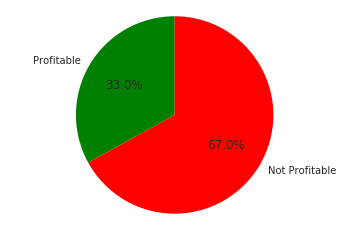

In [87]:
labels="Profitable","Not Profitable"
sizes=[sum(valid_data_models["is_profitable"]==1),sum(valid_data_models["is_profitable"]==0)]
colors=["green","red"]
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%',startangle=90)
 
plt.axis('equal')
plt.show()

**Only about 33% of the movies are "profitable"**

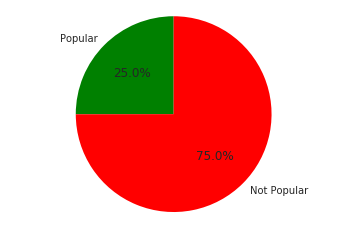

In [88]:
labels="Popular","Not Popular"
sizes=[sum(valid_data_models["is_popular"]==1),sum(valid_data_models["is_popular"]==0)]
colors=["green","red"]
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%',startangle=90)
 
plt.axis('equal')
plt.show()

**About 25% of the movies are "popular" **

# 4) Regression and Classification Models

**We would be performing the following methods to understand and predict Profitability and Popularity of movies**

1. Multi Linear Regression
2. Logistic Regression
3. SVM
4. Decision Tree/Classification Tree
5. Random Forest
6. XGBoost

# 4.1  Regression and Classification for PROFITABILITY

# 4.1.1 Multi-Linear Regression

In [89]:
import statsmodels.api as sm
X=valid_data_models.drop(["is_profitable","Profitability","revenue","popularity","vote_average","vote_count","is_popular","budget"],axis=1)
Y=valid_data_models["revenue"]

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     52.82
Date:                Fri, 13 Apr 2018   Prob (F-statistic):          1.10e-260
Time:                        21:57:23   Log-Likelihood:                -42046.
No. Observations:                2062   AIC:                         8.416e+04
Df Residuals:                    2026   BIC:                         8.437e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
runtime             1.769e+06   2.28e+05      7.748      0.000    1.32e+06    2.22e+06
Animation           8.531e+07   2.12e+07      4.029      0.000    4.38e+07    1.27e+08
Crime               -2.53e+07   1.25e+07     -2.021      0.043   -4.99e+07   -7.52e+05
History            -4.888e+07   2.04e+07     -2.397      0.017   -8.89e+07   -8.89e+06
Horror             -4.459e+07   1.55e+07     -2.877      0.004    -7.5e+07   -1.42e+07
Drama              -7.432e+07   9.77e+06     -7.609      0.000   -9.35e+07   -5.52e+07
Mystery            -1.377e+07   1.59e+07     -0.865      0.387    -4.5e+07    1.74e+07
Documentary        -1.128e+08   3.84e+07     -2.941      0.003   -1.88e+08   -3.76e+07
Fantasy             7.368e+07   1.47e+07      5.010      0.000    4.48e+07    1.03e+08
Action              4.917e+07   1.05e+07      4.687      0.000    2.86e+07    6.97e+07
Thriller           -2.691e+07   1.07e+07     -2.523      0.012   -4.78e+07   -5.99e+06
Music              -2.234e+07   2.49e+07     -0.898      0.369   -7.11e+07    2.64e+07
Comedy             -5.195e+07      1e+07     -5.181      0.000   -7.16e+07   -3.23e+07
Family              5.487e+07   1.81e+07      3.037      0.002    1.94e+07    9.03e+07
Romance            -2.026e+06   1.14e+07     -0.177      0.859   -2.45e+07    2.04e+07
Western            -7.241e+07   4.07e+07     -1.779      0.075   -1.52e+08    7.42e+06
War                -2.027e+07   2.21e+07     -0.917      0.359   -6.37e+07    2.31e+07
Foreign             4.118e+06   4.68e+07      0.088      0.930   -8.77e+07    9.59e+07
Adventure           1.128e+08   1.21e+07      9.356      0.000    8.92e+07    1.36e+08
Western Europe     -6.176e+07   1.04e+07     -5.929      0.000   -8.22e+07   -4.13e+07
Middle Africa       3.294e+07   1.78e+08      0.185      0.853   -3.16e+08    3.81e+08
Northern Africa    -5.792e+07   1.04e+08     -0.558      0.577   -2.62e+08    1.46e+08
Central America    -8.009e+07   5.32e+07     -1.505      0.132   -1.84e+08    2.43e+07
North America      -2.298e+07   1.74e+07     -1.322      0.186   -5.71e+07    1.11e+07
Eastern Asia       -6.032e+07    2.1e+07     -2.870      0.004   -1.02e+08   -1.91e+07
South-Eastern Asia -5.677e+07    4.2e+07     -1.352      0.177   -1.39e+08    2.56e+07
Central Asia       -1.623e-08   6.73e-08     -0.241      0.810   -1.48e-07    1.16e-07
Western Asia       -8.129e+07   6.05e+07     -1.344      0.179      -2e+08    3.73e+07
Eastern Europe     -1.046e+08    1.9e+07     -5.495      0.000   -1.42e+08   -6.72e+07
Oceania            -2.892e+07   2.48e+07     -1.168      0.243   -7.75e+07    1.97e+07
Southern Africa     2.837e-09   1.57e-08      0.181      0.857    -2.8e-08    3.36e-08
Southern Asia      -1.486e+08   1.82e+07     -8.150      0.000   -1.84e+08   -1.13e+08
Caribbean           7.417e+07   5.66e+

**We will first split our training and test set (20%)**

**We will also remove variables that we do not know before a movie is released (e.g profitability, vote counts etc)**

In [90]:
from sklearn.cross_validation import train_test_split
x=valid_data_models.drop(["budget","is_profitable","Profitability","revenue","popularity","vote_average","vote_count","Weighted_ratings","is_popular"],axis=1)
y=valid_data_models["is_profitable"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

**We will use 5-fold cross validation**

In [91]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

**We will create functions to calculate the In-sample accuracy, Test accuracy and to plot our ROC curve and confusion matrix for classifying whether a movie would be PROFITABLE.**

In [92]:
def prof_train_acc_score(model):
    return np.mean(cross_val_score(model,x_train,y_train,cv=k_fold,scoring="accuracy"))
def prof_test_acc_score(model):
    return accuracy_score(y_test, model.predict(x_test))

def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_test,model_used.predict(x_test))
    col=["Predicted Not-Profitable","Predicted Profitable"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Profitable","Predicted Profitable"]
    cm.index=["Actual Not-Profitable","Actual Profitable"]
    #cm[col]=np(cm[col])
    return cm.T

def score(model_used,score):
    cm=confusion_matrix(y_test,model_used.predict(x_test))
    col=["Predicted Not-Profitable","Predicted Profitable"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Profitable","Predicted Profitable"]
    cm.index=["Actual Not-Profitable","Actual Profitable"]
    cm[col]=np.around(cm[col].div(cm[col].sum(axis=1),axis=0),decimals=2)
    if str(score) == "TP":
        return cm.loc["Actual Profitable","Predicted Profitable"]
    elif str(score) == "TN":
        return cm.loc["Actual Not-Profitable","Predicted Not-Profitable"]   
    elif str(score) == "FP":
        return cm.loc["Actual Not-Profitable","Predicted Profitable"]
    elif str(score) == "FN":
        return cm.loc["Actual Profitable","Predicted Not-Profitable"]
    
    
    
def aucscore(model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.decision_function(x_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    return auc
def plt_roc_curve(name,model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.decision_function(x_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    plt.plot(x,y,label='ROC curve for %s (AUC = %0.2f)' % (name, auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
def importance_of_features(model):
    features = pd.DataFrame()
    features['feature'] = x_train.columns
    features['importance'] = model.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    return features.plot(kind='barh', figsize=(10,10))

# 4.1.2 Classification Methods

**Logistic regression (Lasso)**

In [93]:
log_reg1=LogisticRegression(penalty="l1")
log_reg1.fit(x_train,y_train)
predicted=log_reg1.predict(x_test)

print("In-sample accuracy: " + str(prof_train_acc_score(log_reg1)))
print("Test accuracy: " + str(prof_test_acc_score(log_reg1)))
print ("True Positive Rate: " + str(score(log_reg1,"TP")))
print ("True Negative Rate: " + str(score(log_reg1,"TN")))
print ("False Positive Rate: " + str(score(log_reg1,"FP")))
print ("False Negative Rate: " + str(score(log_reg1,"FN")))
confusion_matrix_model(log_reg1)

In-sample accuracy: 0.659799207884
Test accuracy: 0.670702179177
True Positive Rate: 0.05
True Negative Rate: 0.98
False Positive Rate: 0.02
False Negative Rate: 0.95


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,270,130
Predicted Profitable,6,7


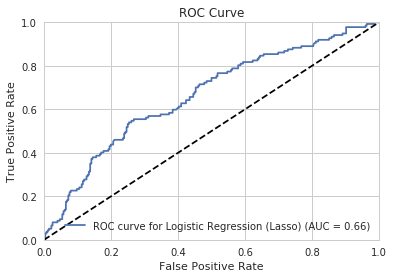

In [94]:
plt_roc_curve("Logistic Regression (Lasso)",log_reg1,has_proba=True)

**Logistic regression (Ridge)**

In [95]:
log_reg2=LogisticRegression(penalty="l2")
log_reg2.fit(x_train,y_train)
predicted=log_reg2.predict(x_test)

print("In-sample accuracy: " + str(prof_train_acc_score(log_reg2)))
print("Test accuracy: " + str(prof_test_acc_score(log_reg2)))
print ("True Positive Rate: " + str(score(log_reg2,"TP")))
print ("True Negative Rate: " + str(score(log_reg2,"TN")))
print ("False Positive Rate: " + str(score(log_reg2,"FP")))
print ("False Negative Rate: " + str(score(log_reg2,"FN")))
confusion_matrix_model(log_reg2)

In-sample accuracy: 0.662831353044
Test accuracy: 0.668280871671
True Positive Rate: 0.06
True Negative Rate: 0.97
False Positive Rate: 0.03
False Negative Rate: 0.94


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,268,129
Predicted Profitable,8,8


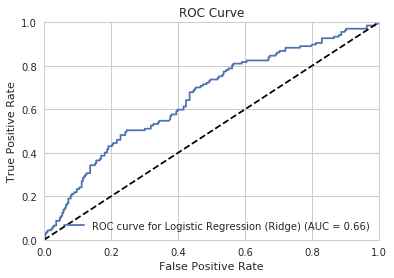

In [96]:
plt_roc_curve("Logistic Regression (Ridge)",log_reg2,has_proba=True)

**SVM**

In [97]:
from sklearn import svm
SVM=svm.LinearSVC()
SVM.fit(x_train,y_train)
predicted=SVM.predict(x_test)

print("In-sample accuracy: " + str(prof_train_acc_score(SVM)))
print("Test accuracy: " + str(prof_test_acc_score(SVM)))
print ("True Positive Rate: " + str(score(SVM,"TP")))
print ("True Negative Rate: " + str(score(SVM,"TN")))
print ("False Positive Rate: " + str(score(SVM,"FP")))
print ("False Negative Rate: " + str(score(SVM,"FN")))
confusion_matrix_model(SVM)

In-sample accuracy: 0.545257437598
Test accuracy: 0.360774818402
True Positive Rate: 0.99
True Negative Rate: 0.05
False Positive Rate: 0.95
False Negative Rate: 0.01


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,14,2
Predicted Profitable,262,135


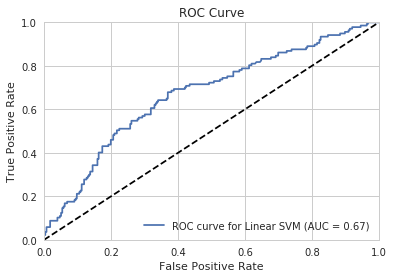

In [98]:
plt_roc_curve("Linear SVM",SVM,has_proba=False)

**KNN**

In [99]:
KNN=KNeighborsClassifier(n_neighbors=30)
KNN.fit(x_train,y_train)
predicted=KNN.predict(x_test)
print("In-sample accuracy: " + str(prof_train_acc_score(KNN)))
print("Test accuracy: " + str(prof_test_acc_score(KNN)))
print ("True Positive Rate: " + str(score(KNN,"TP")))
print ("True Negative Rate: " + str(score(KNN,"TN")))
print ("False Positive Rate: " + str(score(KNN,"FP")))
print ("False Negative Rate: " + str(score(KNN,"FN")))
confusion_matrix_model(KNN)

In-sample accuracy: 0.653128856959
Test accuracy: 0.680387409201
True Positive Rate: 0.04
True Negative Rate: 1.0
False Positive Rate: 0.0
False Negative Rate: 0.96


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,276,132
Predicted Profitable,0,5


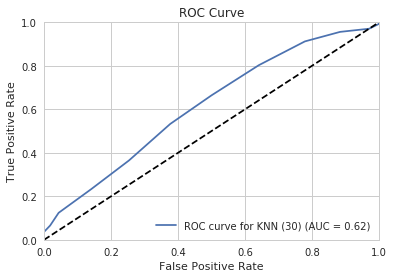

In [100]:
plt_roc_curve("KNN (30)",KNN,has_proba=True)

**Decision Tree/Classification Tree**

In [101]:
Dec_tree=DecisionTreeClassifier(max_depth=4,random_state=5)
Dec_tree.fit(x_train,y_train)
predicted=Dec_tree.predict(x_test)
print("In-sample accuracy: " + str(prof_train_acc_score(Dec_tree)))
print("Test accuracy: " + str(prof_test_acc_score(Dec_tree)))
print ("True Positive Rate: " + str(score(Dec_tree,"TP")))
print ("True Negative Rate: " + str(score(Dec_tree,"TN")))
print ("False Positive Rate: " + str(score(Dec_tree,"FP")))
print ("False Negative Rate: " + str(score(Dec_tree,"FN")))
confusion_matrix_model(Dec_tree)

In-sample accuracy: 0.664636639956
Test accuracy: 0.690072639225
True Positive Rate: 0.17
True Negative Rate: 0.95
False Positive Rate: 0.05
False Negative Rate: 0.83


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,262,114
Predicted Profitable,14,23


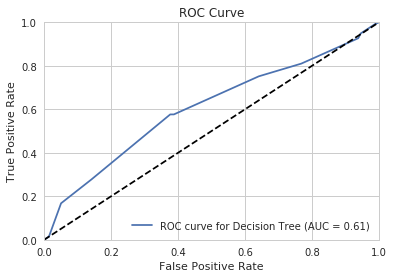

In [102]:
plt_roc_curve("Decision Tree",Dec_tree,has_proba=True)

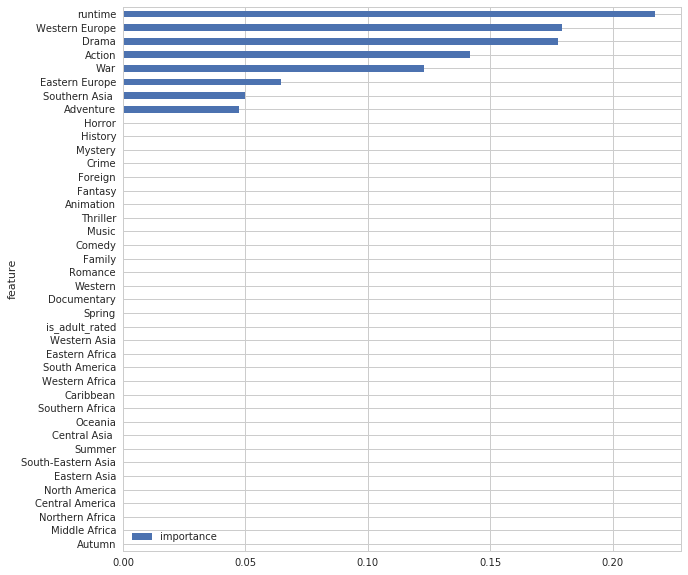

In [103]:
importance_of_features(Dec_tree)

**Random Forest**

In [104]:
ranfor = RandomForestClassifier(n_estimators=50, max_features='sqrt',max_depth=6,random_state=10)
ranfor = ranfor.fit(x_train,y_train)
predicted=ranfor.predict(x_test)
print("In-sample accuracy: " + str(prof_train_acc_score(ranfor)))
print("Test accuracy: " + str(prof_test_acc_score(ranfor)))
print ("True Positive Rate: " + str(score(ranfor,"TP")))
print ("True Negative Rate: " + str(score(ranfor,"TN")))
print ("False Positive Rate: " + str(score(ranfor,"FP")))
print ("False Negative Rate: " + str(score(ranfor,"FN")))
confusion_matrix_model(ranfor)

In-sample accuracy: 0.667071935157
Test accuracy: 0.673123486683
True Positive Rate: 0.02
True Negative Rate: 1.0
False Positive Rate: 0.0
False Negative Rate: 0.98


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,275,134
Predicted Profitable,1,3


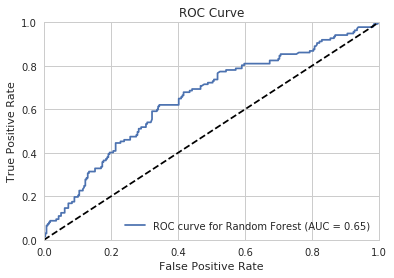

In [105]:
plt_roc_curve("Random Forest",ranfor,has_proba=True)

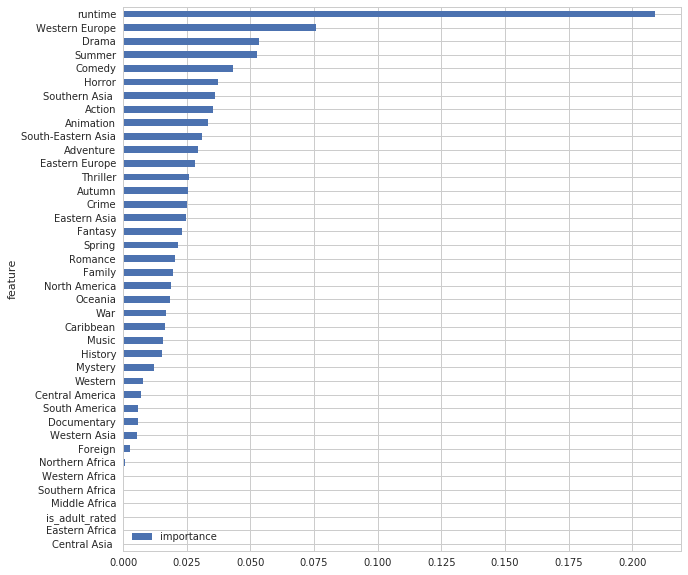

In [106]:
importance_of_features(ranfor)

**XGboosting**

In [107]:
xgclass = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.01).fit(x_train, y_train)
predicted=xgclass.predict(x_test)
print("In-sample accuracy: " + str(prof_train_acc_score(xgclass)))
print("Test accuracy: " + str(prof_test_acc_score(xgclass)))
print ("True Positive Rate: " + str(score(xgclass,"TP")))
print ("True Negative Rate: " + str(score(xgclass,"TN")))
print ("False Positive Rate: " + str(score(xgclass,"FP")))
print ("False Negative Rate: " + str(score(xgclass,"FN")))
confusion_matrix_model(xgclass)

In-sample accuracy: 0.66525006908
Test accuracy: 0.670702179177
True Positive Rate: 0.06
True Negative Rate: 0.97
False Positive Rate: 0.03
False Negative Rate: 0.94


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,269,129
Predicted Profitable,7,8


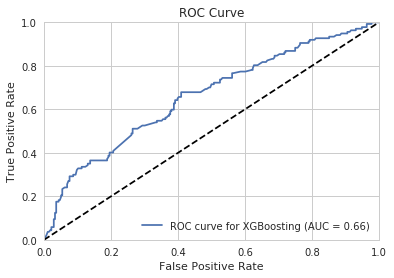

In [108]:
plt_roc_curve("XGBoosting",xgclass,has_proba=True)

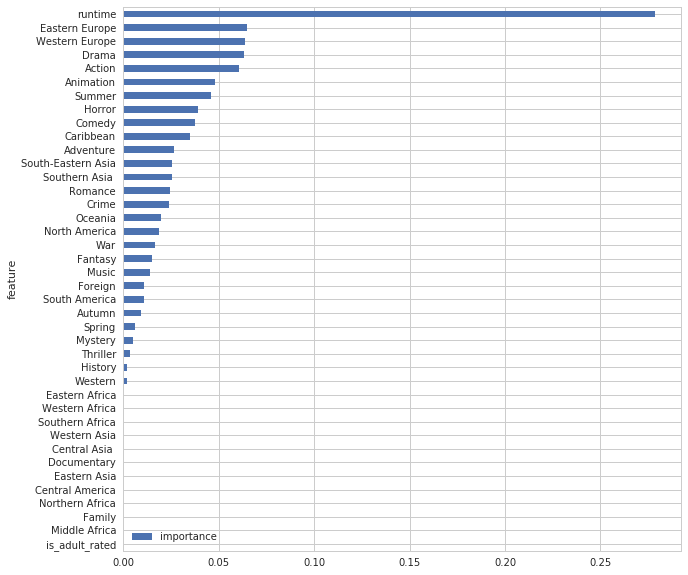

In [109]:
importance_of_features(xgclass)

# 4.1.3 Results for Classification methods for profitability

In [110]:
Classifiers=["Logistic Regression (Lasso)","Logistic Regression (Ridge)","Support Vector Machine","K-Nearest Neighbours","Decision Tree","Random Forest","XGBoost"]
in_sample_acc=[prof_train_acc_score(x) for x in [log_reg1,log_reg2,SVM,KNN,Dec_tree,ranfor,xgclass]]
test_acc=[prof_test_acc_score(x) for x in [log_reg1,log_reg2,SVM,KNN,Dec_tree,ranfor,xgclass]]
auc_scores_prob=[aucscore(x,has_proba=True) for x in [log_reg1,log_reg2,KNN,Dec_tree,ranfor,xgclass]]
auc_scores_noprob=[aucscore(x,has_proba=False) for x in [SVM]]
auc_scores=auc_scores_prob[:2] + auc_scores_noprob + auc_scores_prob[2:]
TP_rate = [score(x,"TP") for x in [log_reg1,log_reg2,SVM,KNN,Dec_tree,ranfor,xgclass]]
TN_rate = [score(x,"TN") for x in [log_reg1,log_reg2,SVM,KNN,Dec_tree,ranfor,xgclass]]
cols=["Classifier","In-sample Accuracy","Test Accuracy","AUC"]
profit_results = pd.DataFrame(columns=cols)
profit_results["Classifier"]=Classifiers
profit_results["In-sample Accuracy"]=in_sample_acc
profit_results["Test Accuracy"]=test_acc
profit_results["AUC"]=auc_scores
profit_results["TP Rate"]=TP_rate
profit_results["TN Rate"]=TN_rate
profit_results

,Classifier,In-sample Accuracy,Test Accuracy,AUC,TP Rate,TN Rate
0,Logistic Regression (Lasso),0.659193,0.670702,0.663771,0.05,0.98
1,Logistic Regression (Ridge),0.662831,0.668281,0.655665,0.06,0.97
2,Support Vector Machine,0.601009,0.360775,0.669655,0.99,0.05
3,K-Nearest Neighbours,0.653129,0.680387,0.615625,0.04,1.00
4,Decision Tree,0.664637,0.690073,0.605668,0.17,0.95
5,Random Forest,0.667072,0.673123,0.651658,0.02,1.00
6,XGBoost,0.665250,0.670702,0.660081,0.06,0.97


# 4.2  Regression and Classification for POPULARITY

# 4.2.1 Multi-Linear Regression

In [111]:
X=valid_data_models.drop(["budget","is_profitable","Profitability","revenue","popularity","vote_average","vote_count","Weighted_ratings","is_popular"],axis=1)
Y=valid_data_models["Weighted_ratings"]

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Weighted_ratings   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     3069.
Date:                Fri, 13 Apr 2018   Prob (F-statistic):               0.00
Time:                        21:57:31   Log-Likelihood:                -2472.0
No. Observations:                2062   AIC:                             5014.
Df Residuals:                    2027   BIC:                             5211.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
runtime                0.0416      0.001     81.263      0.000       0.041       0.043
Animation              0.8704      0.096      9.072      0.000       0.682       1.059
Crime                  0.0327      0.058      0.566      0.572      -0.081       0.146
History               -0.3260      0.094     -3.468      0.001      -0.510      -0.142
Horror                 0.8852      0.069     12.849      0.000       0.750       1.020
Drama                  0.4002      0.044      9.040      0.000       0.313       0.487
Mystery                0.0545      0.074      0.741      0.459      -0.090       0.199
Documentary            1.2799      0.175      7.310      0.000       0.937       1.623
Fantasy                0.1163      0.068      1.713      0.087      -0.017       0.250
Action                 0.3062      0.048      6.377      0.000       0.212       0.400
Thriller               0.4066      0.048      8.388      0.000       0.312       0.502
Music                  0.0764      0.115      0.665      0.506      -0.149       0.302
Comedy                 0.8158      0.043     19.123      0.000       0.732       0.899
Family                 0.3420      0.083      4.113      0.000       0.179       0.505
Romance                0.0660      0.053      1.250      0.211      -0.038       0.170
Western                0.1465      0.188      0.779      0.436      -0.222       0.516
War                   -0.0196      0.102     -0.192      0.848      -0.220       0.181
Foreign               -0.1769      0.216     -0.818      0.413      -0.601       0.247
Adventure              0.0049      0.056      0.089      0.929      -0.104       0.114
Western Europe         0.1312      0.048      2.729      0.006       0.037       0.225
Middle Africa         -0.6497      0.821     -0.791      0.429      -2.261       0.961
Northern Africa       -0.7611      0.480     -1.587      0.113      -1.702       0.179
Central America       -0.0509      0.246     -0.207      0.836      -0.533       0.431
North America          0.0951      0.080      1.184      0.237      -0.062       0.253
Eastern Asia          -0.0158      0.097     -0.163      0.871      -0.206       0.175
South-Eastern Asia    -0.3541      0.194     -1.826      0.068      -0.734       0.026
Central Asia       -5.822e-16   2.49e-16     -2.338      0.019   -1.07e-15   -9.38e-17
Western Asia           0.4107      0.279      1.470      0.142      -0.137       0.959
Eastern Europe         0.4478      0.087      5.124      0.000       0.276       0.619
Oceania                0.0935      0.114      0.816      0.414      -0.131       0.318
Southern Africa    -1.651e-16   1.21e-16     -1.360      0.174   -4.03e-16     7.3e-17
Southern Asia         -1.2458      0.080    -15.644      0.000      -1.402      -1.090
Caribbean             -0.0688      0.2

**We will first split our training and test set (20%)**

**We will also remove variables that we do not know before a movie is released (e.g profitability, vote counts etc)**

In [112]:
x_pop=valid_data_models.drop(["budget","is_profitable","Profitability","revenue","popularity","vote_average","vote_count","Weighted_ratings","is_popular"],axis=1)
y_pop=valid_data_models["is_popular"]
x_pop_train,x_pop_test,y_pop_train,y_pop_test=train_test_split(x_pop,y_pop,test_size=0.2,random_state=0)

**We will use 5-fold cross validation**

In [113]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

**We will create functions to calculate the In-sample accuracy, Test accuracy and to plot our ROC curve and confusion matrix for classifying whether a movie would be POPULAR.**

In [114]:
def pop_train_acc_score(model):
    return np.mean(cross_val_score(model,x_pop_train,y_pop_train,cv=k_fold,scoring="accuracy"))
def pop_test_acc_score(model):
    return accuracy_score(y_pop_test, model.predict(x_pop_test))
def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_pop_test,model_used.predict(x_pop_test))
    col=["Predicted Not-Popular","Predicted Popular"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Popular","Predicted Popular"]
    cm.index=["Actual Not-Popular","Actual Popular"]
    #cm[col]=np(cm[col])
    return cm.T
def score(model_used,score):
    cm=confusion_matrix(y_pop_test,model_used.predict(x_pop_test))
    col=["Predicted Not-Popular","Predicted Popular"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Popular","Predicted Popular"]
    cm.index=["Actual Not-Popular","Actual Popular"]
    cm[col]=np.around(cm[col].div(cm[col].sum(axis=1),axis=0),decimals=2)
    if str(score) == "TP":
        return cm.loc["Actual Popular","Predicted Popular"]
    elif str(score) == "TN":
        return cm.loc["Actual Not-Popular","Predicted Not-Popular"]   
    elif str(score) == "FP":
        return cm.loc["Actual Not-Popular","Predicted Popular"]
    elif str(score) == "FN":
        return cm.loc["Actual Popular","Predicted Not-Popular"]

def aucscore(model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.predict_proba(x_pop_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.decision_function(x_pop_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    return auc
def plt_roc_curve(name,model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.predict_proba(x_pop_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.decision_function(x_pop_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    plt.plot(x,y,label='ROC curve for %s (AUC = %0.2f)' % (name, auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
def importance_of_features(model):
    features = pd.DataFrame()
    features['feature'] = x_pop_train.columns
    features['importance'] = model.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    return features.plot(kind='barh', figsize=(10,10))

# 4.2.2 Classification Methods

**Logistic regression (Lasso)**

In [115]:
from sklearn.metrics import accuracy_score
log_reg1_pop=LogisticRegression(penalty="l1")
log_reg1_pop.fit(x_pop_train,y_pop_train)
predicted=log_reg1_pop.predict(x_pop_test)

print("In-sample accuracy: " + str(pop_train_acc_score(log_reg1_pop)))
print("Test accuracy: " + str(pop_test_acc_score(log_reg1_pop)))
print ("True Positive Rate: " + str(score(log_reg1_pop,"TP")))
print ("True Negative Rate: " + str(score(log_reg1_pop,"TN")))
print ("False Positive Rate: " + str(score(log_reg1_pop,"FP")))
print ("False Negative Rate: " + str(score(log_reg1_pop,"FN")))
confusion_matrix_model(log_reg1_pop)

In-sample accuracy: 0.769555125725
Test accuracy: 0.765133171913
True Positive Rate: 0.23
True Negative Rate: 0.96
False Positive Rate: 0.04
False Negative Rate: 0.77


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,291,86
Predicted Popular,11,25


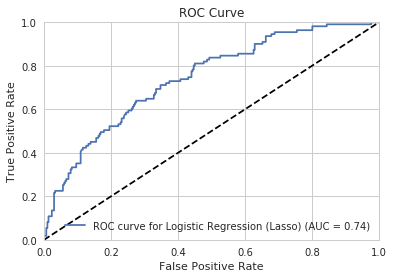

In [116]:
plt_roc_curve("Logistic Regression (Lasso)",log_reg1_pop,has_proba=True)

**Logistic regression (Ridge)**

In [117]:
from sklearn.metrics import accuracy_score
log_reg2_pop=LogisticRegression(penalty="l2")
log_reg2_pop.fit(x_pop_train,y_pop_train)
predicted=log_reg2_pop.predict(x_pop_test)

print("In-sample accuracy: " + str(pop_train_acc_score(log_reg2_pop)))
print("Test accuracy: " + str(pop_test_acc_score(log_reg2_pop)))
print ("True Positive Rate: " + str(score(log_reg2_pop,"TP")))
print ("True Negative Rate: " + str(score(log_reg2_pop,"TN")))
print ("False Positive Rate: " + str(score(log_reg2_pop,"FP")))
print ("False Negative Rate: " + str(score(log_reg2_pop,"FN")))
confusion_matrix_model(log_reg2_pop)

In-sample accuracy: 0.768335635995
Test accuracy: 0.753026634383
True Positive Rate: 0.16
True Negative Rate: 0.97
False Positive Rate: 0.03
False Negative Rate: 0.84


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,293,93
Predicted Popular,9,18


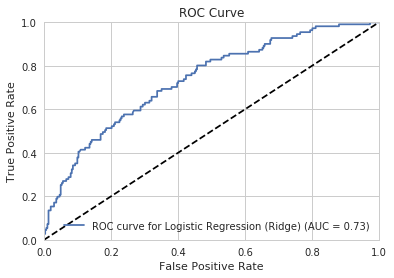

In [118]:
plt_roc_curve("Logistic Regression (Ridge)",log_reg2_pop,has_proba=True)

**SVM**

In [119]:
from sklearn import svm
SVM_pop=svm.LinearSVC()
SVM_pop.fit(x_pop_train,y_pop_train)
predicted=SVM_pop.predict(x_pop_test)

print("In-sample accuracy: " + str(pop_train_acc_score(SVM_pop)))
print("Test accuracy: " + str(pop_test_acc_score(SVM_pop)))
print ("True Positive Rate: " + str(score(SVM_pop,"TP")))
print ("True Negative Rate: " + str(score(SVM_pop,"TN")))
print ("False Positive Rate: " + str(score(SVM_pop,"FP")))
print ("False Negative Rate: " + str(score(SVM_pop,"FN")))
confusion_matrix_model(SVM_pop)

In-sample accuracy: 0.574737036014
Test accuracy: 0.731234866828
True Positive Rate: 0.0
True Negative Rate: 1.0
False Positive Rate: 0.0
False Negative Rate: 1.0


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,302,111
Predicted Popular,0,0


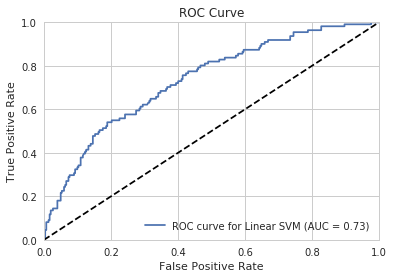

In [120]:
plt_roc_curve("Linear SVM",SVM_pop,has_proba=False)

**KNN**

In [121]:
KNN_pop=KNeighborsClassifier(n_neighbors=30)
KNN_pop.fit(x_pop_train,y_pop_train)
predicted=KNN_pop.predict(x_pop_test)
print("In-sample accuracy: " + str(pop_train_acc_score(KNN_pop)))
print("Test accuracy: " + str(pop_test_acc_score(KNN_pop)))
print ("True Positive Rate: " + str(score(KNN_pop,"TP")))
print ("True Negative Rate: " + str(score(KNN_pop,"TN")))
print ("False Positive Rate: " + str(score(KNN_pop,"FP")))
print ("False Negative Rate: " + str(score(KNN_pop,"FN")))
confusion_matrix_model(KNN_pop)

In-sample accuracy: 0.748928801695
Test accuracy: 0.726392251816
True Positive Rate: 0.08
True Negative Rate: 0.96
False Positive Rate: 0.04
False Negative Rate: 0.92


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,291,102
Predicted Popular,11,9


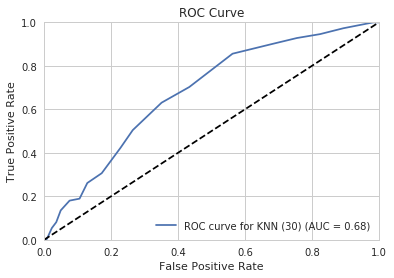

In [122]:
plt_roc_curve("KNN (30)",KNN_pop,has_proba=True)

**Decision Tree/Classification Tree**

In [123]:
Dec_tree_pop=DecisionTreeClassifier(max_depth=4,random_state=5)
Dec_tree_pop.fit(x_pop_train,y_pop_train)
predicted=Dec_tree_pop.predict(x_pop_test)
print("In-sample accuracy: " + str(pop_train_acc_score(Dec_tree_pop)))
print("Test accuracy: " + str(pop_test_acc_score(Dec_tree_pop)))
print ("True Positive Rate: " + str(score(Dec_tree_pop,"TP")))
print ("True Negative Rate: " + str(score(Dec_tree_pop,"TN")))
print ("False Positive Rate: " + str(score(Dec_tree_pop,"FP")))
print ("False Negative Rate: " + str(score(Dec_tree_pop,"FN")))
confusion_matrix_model(Dec_tree_pop)

In-sample accuracy: 0.748330109607
Test accuracy: 0.74818401937
True Positive Rate: 0.25
True Negative Rate: 0.93
False Positive Rate: 0.07
False Negative Rate: 0.75


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,281,83
Predicted Popular,21,28


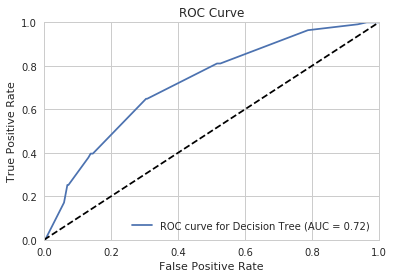

In [124]:
plt_roc_curve("Decision Tree",Dec_tree_pop,has_proba=True)

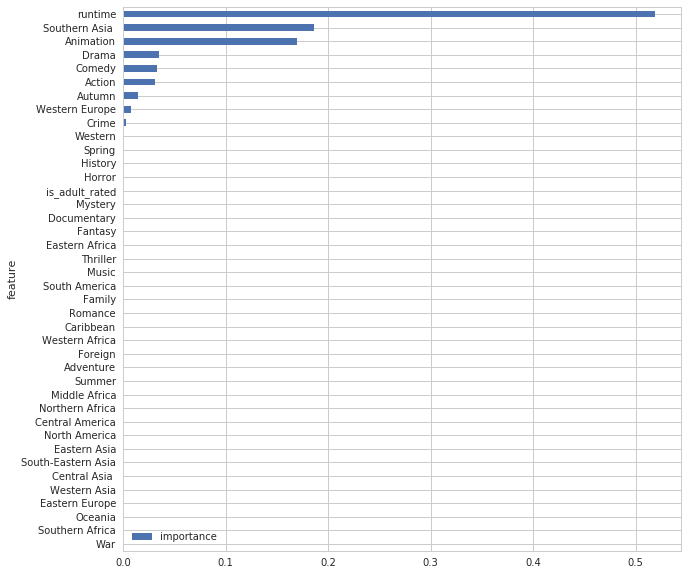

In [125]:
importance_of_features(Dec_tree_pop)

**Random Forest**

In [126]:
ranfor_pop = RandomForestClassifier(n_estimators=50, max_features='sqrt',max_depth=6,random_state=10)
ranfor_pop = ranfor_pop.fit(x_pop_train,y_pop_train)
predicted=ranfor_pop.predict(x_pop_test)
print("In-sample accuracy: " + str(pop_train_acc_score(ranfor_pop)))
print("Test accuracy: " + str(pop_test_acc_score(ranfor_pop)))
print ("True Positive Rate: " + str(score(ranfor_pop,"TP")))
print ("True Negative Rate: " + str(score(ranfor_pop,"TN")))
print ("False Positive Rate: " + str(score(ranfor_pop,"FP")))
print ("False Negative Rate: " + str(score(ranfor_pop,"FN")))
confusion_matrix_model(ranfor_pop)

In-sample accuracy: 0.759248411163
Test accuracy: 0.738498789346
True Positive Rate: 0.05
True Negative Rate: 0.99
False Positive Rate: 0.01
False Negative Rate: 0.95


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,300,106
Predicted Popular,2,5


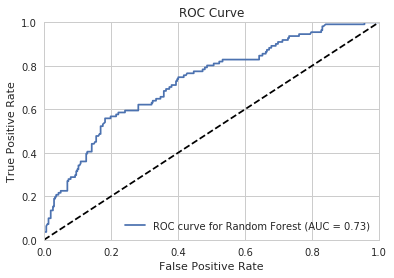

In [127]:
plt_roc_curve("Random Forest",ranfor_pop,has_proba=True)

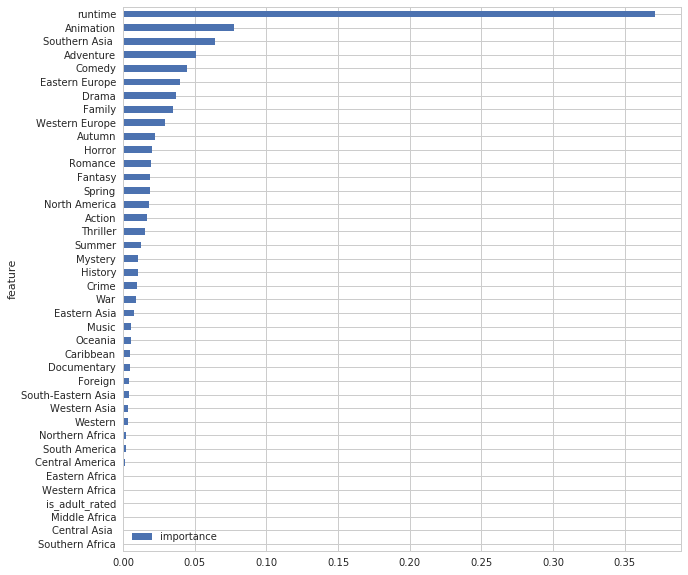

In [128]:
importance_of_features(ranfor_pop)

**XGBoosting**

In [129]:
xgclass_pop = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.01).fit(x_pop_train, y_pop_train)
predicted=xgclass_pop.predict(x_pop_test)
print("In-sample accuracy: " + str(pop_train_acc_score(xgclass_pop)))
print("Test accuracy: " + str(pop_test_acc_score(xgclass_pop)))
print ("True Positive Rate: " + str(score(xgclass_pop,"TP")))
print ("True Negative Rate: " + str(score(xgclass_pop,"TN")))
print ("False Positive Rate: " + str(score(xgclass_pop,"FP")))
print ("False Negative Rate: " + str(score(xgclass_pop,"FN")))
confusion_matrix_model(xgclass_pop)

In-sample accuracy: 0.768939854472
Test accuracy: 0.753026634383
True Positive Rate: 0.23
True Negative Rate: 0.94
False Positive Rate: 0.06
False Negative Rate: 0.77


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,285,85
Predicted Popular,17,26


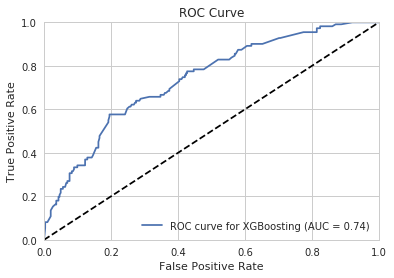

In [130]:
plt_roc_curve("XGBoosting",xgclass_pop,has_proba=True)

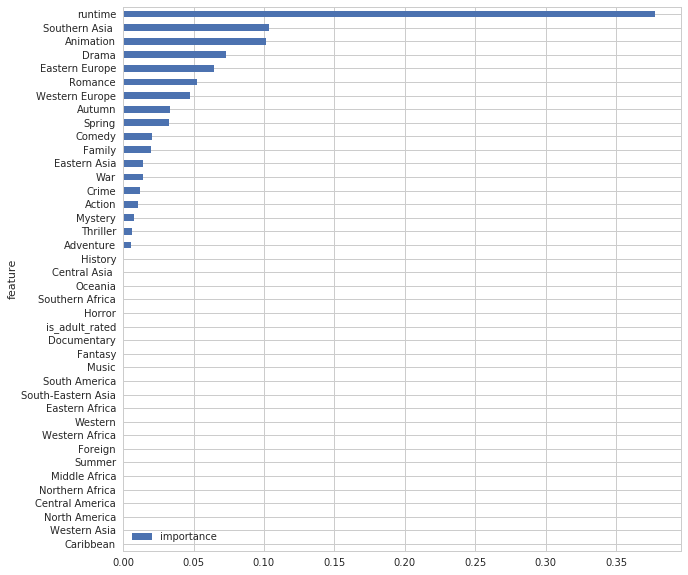

In [131]:
importance_of_features(xgclass_pop)

# 4.2.3 Results for Classification methods for popularity

In [132]:
Classifiers=["Logistic Regression (Lasso)","Logistic Regression (Ridge)","Support Vector Machine","K-Nearest Neighbours","Decision Tree","Random Forest","XGBoost"]
in_sample_acc=[pop_train_acc_score(x) for x in [log_reg1_pop,log_reg2_pop,SVM_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
test_acc=[pop_test_acc_score(x) for x in [log_reg1_pop,log_reg2_pop,SVM_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
auc_scores_prob=[aucscore(x,has_proba=True) for x in [log_reg1_pop,log_reg2_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
auc_scores_noprob=[aucscore(x,has_proba=False) for x in [SVM_pop]]
auc_scores=auc_scores_prob[:2] + auc_scores_noprob + auc_scores_prob[2:]
TP_rate = [score(x,"TP") for x in [log_reg1_pop,log_reg2_pop,SVM_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
TN_rate = [score(x,"TN") for x in [log_reg1_pop,log_reg2_pop,SVM_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
cols=["Classifier","In-sample Accuracy","Test Accuracy","AUC"]
popularity_results = pd.DataFrame(columns=cols)
popularity_results["Classifier"]=Classifiers
popularity_results["In-sample Accuracy"]=in_sample_acc
popularity_results["Test Accuracy"]=test_acc
popularity_results["AUC"]=auc_scores
popularity_results["TP Rate"]=TP_rate
popularity_results["TN Rate"]=TN_rate
popularity_results

,Classifier,In-sample Accuracy,Test Accuracy,AUC,TP Rate,TN Rate
0,Logistic Regression (Lasso),0.768949,0.765133,0.742408,0.23,0.96
1,Logistic Regression (Ridge),0.768336,0.753027,0.734831,0.16,0.97
2,Support Vector Machine,0.355306,0.731235,0.732892,0.00,1.00
3,K-Nearest Neighbours,0.748929,0.726392,0.679942,0.08,0.96
4,Decision Tree,0.748330,0.748184,0.717797,0.25,0.93
5,Random Forest,0.759248,0.738499,0.726955,0.05,0.99
6,XGBoost,0.768940,0.753027,0.736352,0.23,0.94
